## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
!pip install -qq svgpath2mpl svgpathtools

In [3]:
# Standard library
import json
from pathlib import Path

# Plotting, figure settings, math
import matplotlib
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.transforms import Affine2D
from numpy import eye, set_printoptions
from svgpath2mpl import parse_path
from svgpathtools import svg2paths

# ProMis
from promis import ProMis, StaRMap
from promis.geo import CartesianMap, CartesianRasterBand, PolarLocation
from promis.loaders import NauticalChartLoader
from promis.logic.spatial.depth import Depth

# Use full width of juptyer notebook
set_printoptions(linewidth=180, formatter={"float_kind": "{:4.6f}".format})
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42

## General setting

In [4]:
origin = PolarLocation(latitude=40.5268, longitude=-74.0278)
dimensions = width, height = (25_000.0, 25_000.0)

## Load chart data

This only needs to be done once.

In [39]:
uam = NauticalChartLoader(
    chart_root=Path(".").absolute().parent / "data" / "us_charts" / "US4NY1AM",
    origin=origin,
    dimensions=dimensions,
).load_chart_data()

uam.apply_covariance(20.0 * eye(2))

In [40]:
print(f"Loaded {len(uam.features)} features:")
print()

for feature in uam.features:
    # Water is visualized below anyways
    if feature.location_type != "water":
        print(f"{type(feature).__name__} - {feature.location_type}: \t{feature.name}")

Loaded 146 features:

CartesianPolygon - anchorage: 	US4NY1AM#0226023689210032 (Anchorage Area): "---"
CartesianLocation - obstruction: 	US4NY1AM#022602243BBC0032 (Buoy (BOYLAT)): "Sandy Hook Channel Lighted Buoy 12"
CartesianLocation - obstruction: 	US4NY1AM#02260220CA580032 (Buoy (BOYLAT)): "Rockaway Inlet Lighted Bell Buoy 2"
CartesianLocation - obstruction: 	US4NY1AM#0226022439970032 (Buoy (BOYLAT)): "Ambrose Channel Lighted Buoy 8"
CartesianLocation - obstruction: 	US4NY1AM#0226022439AA0032 (Buoy (BOYLAT)): "Ambrose Channel Lighted Buoy 9"
CartesianLocation - obstruction: 	US4NY1AM#0226022443E90032 (Buoy (BOYLAT)): "Sandy Hook Channel Lighted Buoy 4"
CartesianLocation - obstruction: 	US4NY1AM#0226022443300032 (Buoy (BOYLAT)): "Sandy Hook Channel Lighted Gong Buoy 1"
CartesianLocation - obstruction: 	US4NY1AM#022602243B2C0032 (Buoy (BOYLAT)): "Sandy Hook Channel Lighted Buoy 2"
CartesianLocation - obstruction: 	US4NY1AM#02260224361A0032 (Buoy (BOYLAT)): "Ambrose Channel Lighted Buo

In [41]:
uam.save("nautical_chart_uam.pkl")

## Prepare the mission landscape

In [65]:
# Load a UAM
uam = CartesianMap.load("nautical_chart_uam.pkl")

# We create a statistical relational map (StaR Map) to represent the
# stochastic relationships in the environment, computing a raster of 100 x 100 points
# using linear interpolation of a sample set
target_resolution = (200, 200)
target = CartesianRasterBand(origin, target_resolution, width, height)
star_map = StaRMap(target, uam, method="linear")

# The sample points for which the relations will be computed directly
support_resolution = (50, 50)
support = CartesianRasterBand(origin, support_resolution, width, height)

# We now compute the Distance and Over relationships for the selected points
# For this, we take many random samples from generated/possible map variations
star_map.add_support_points(support, 25)

## Use it!

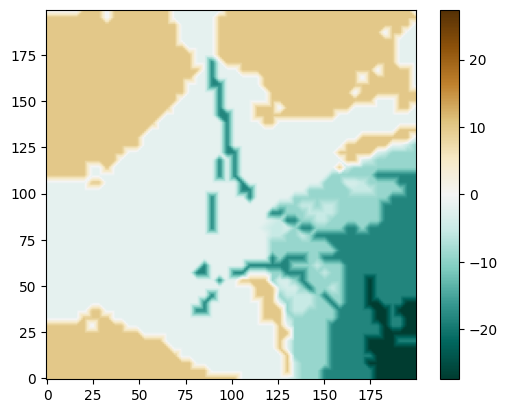

<Figure size 640x480 with 0 Axes>

In [73]:
# We first plot the depth since it is not asoociated with a specific location type
depth: Depth = star_map.get("depth", None)
depth.plot(target_resolution)
plt.show()
plt.clf()

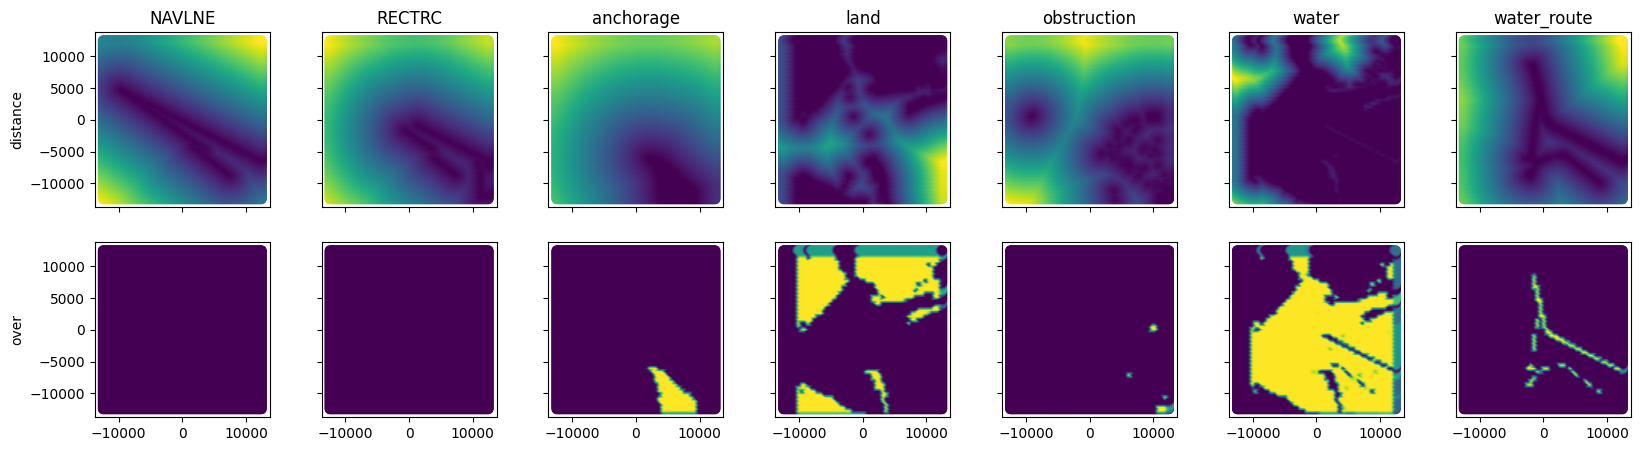

<Figure size 640x480 with 0 Axes>

In [80]:
# Plot an overview of the map
all_relation_types = sorted(star_map.relation_types - {"depth"})
all_location_types = sorted(set(star_map.location_types) - {None})

# Create one row per relation type and one column per location type
fig, axes = plt.subplots(
    len(all_relation_types), len(all_location_types), figsize=(20, 5), sharex=True, sharey=True
)

for i, relation_type in enumerate(all_relation_types):
    for j, location_type in enumerate(all_location_types):
        # Get the axis for the current row and column
        ax = axes[i, j]

        # Label the rows and columns
        if j == 0:
            ax.set_ylabel(relation_type)
        if i == 0:
            ax.set_title(location_type)

        # Get the relation and visualize it
        relation = star_map.get(relation_type, location_type)
        relation.parameters.scatter(axis=ax)

        # if j == len(all_location_types) - 1:
        #     plt.colorbar()

plt.show()
plt.clf()

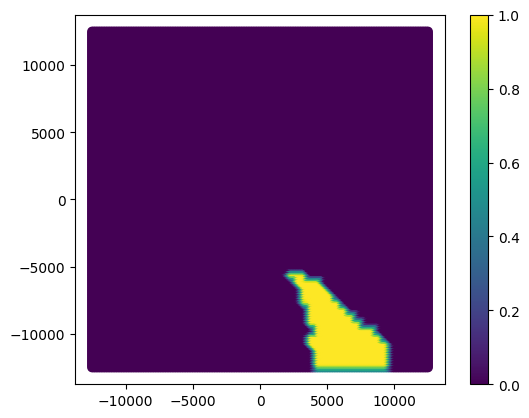

<Figure size 640x480 with 0 Axes>

In [49]:
relation = star_map.get("over", "anchorage")
relation.parameters.scatter(vmin=0)
plt.colorbar()
plt.show()
plt.clf()

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/local/lib/pytho

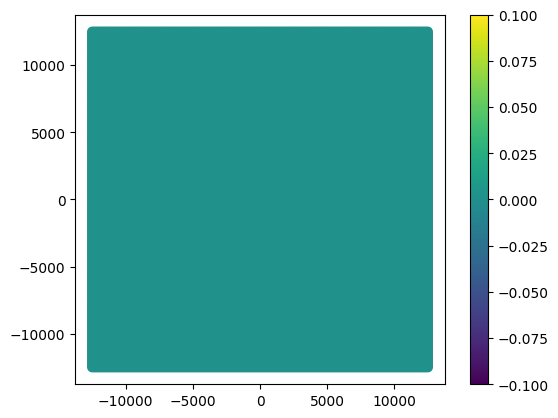

<Figure size 640x480 with 0 Axes>

In [10]:
# In ProMis, we define the constraints of the mission
# as hybrid probabilistic first-order logic program
logic = """
% The Probabilistic Mission Landscape
%landscape(X) :- depth(X) < -1.5.
landscape(X) :- over(X, 'RECTRC').
"""

# Solve mission constraints using StaRMap parameters and multiprocessing
promis = ProMis(star_map)
landscape = promis.solve(logic, n_jobs=12, batch_size=10, show_progress=False)

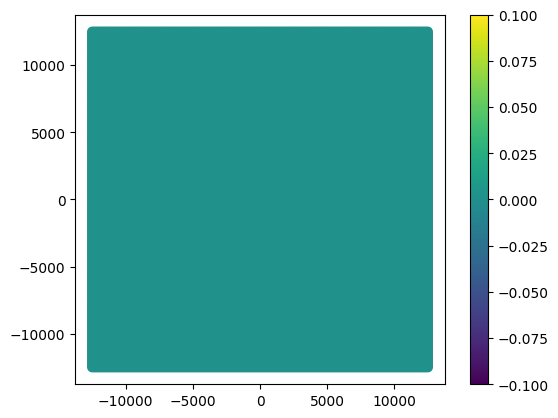

<Figure size 640x480 with 0 Axes>

In [35]:
# Show the resulting landscape
landscape.scatter()
plt.colorbar()
plt.show()
plt.clf()

In [11]:
landscape.save("ship_landscape.pkl")

## Simulate other ships

In [12]:
import numpy as np
import numpy.linalg
from matplotlib.animation import FuncAnimation
from numpy import argmax, array, ndarray
from scipy.stats import norm, uniform

from promis.estimators.filters.particle import (
    ParticleFilter,
    gaussian_noise,
    independent_sample,
    squared_error,
)


In [13]:
landscape = CartesianRasterBand.load("ship_landscape.pkl")

In [14]:
def closest_landscape(positions: ndarray) -> float:
    differences = landscape.data[["east", "north"]].values[:, None, :] - positions[None, :, :]
    ind = argmax(-numpy.linalg.norm(differences, axis=-1, ord=2), axis=0)
    return landscape.data["v0"][ind].to_numpy()


closest_landscape(array([[-1300, 200], [0, 0], [2000, 2000]]))

array([0.000000, 0.000000, 0.000000])

### Measurment

In [15]:
# linear movement.
# first going from (-1500, 0) to (0, 0) in 50 steps,
# and then going from (0, 0) to (1500, -800) in 50 steps
ground_truth = array(
    [(-1500 + i * 60, 0) for i in range(26)] + [(i * 60, -i * 32) for i in range(26)]
)
ground_truth.shape

(52, 2)

In [16]:
ship_speed = 20  # meters per second
entire_time = width / ship_speed
num_samples = len(ground_truth)
sample_time = entire_time / num_samples

sample_time

24.03846153846154

In [17]:
def plot_trajectories(all_positions, label: str | None = "Trajectory {}", **kwargs):
    if len(all_positions.shape) == 2:
        all_positions = all_positions[None, ...]
    for i, positions in enumerate(all_positions):
        plt.plot(*zip(*positions), label=label.format(i) if label else None, **kwargs)

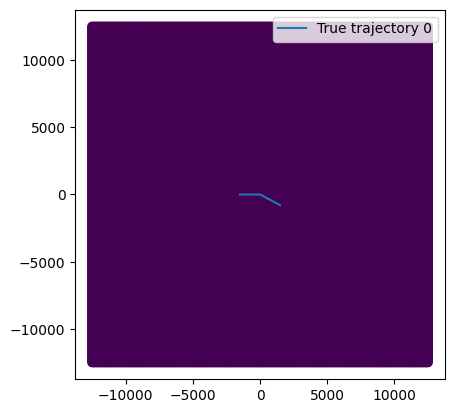

In [18]:
landscape.scatter()
plot_trajectories(ground_truth, label="True trajectory {}")
plt.legend()
pass

In [19]:
def plot_trajectories_animated(positions, filename: str = "trajectory.gif") -> None:
    fig, _ = plt.subplots()
    landscape.scatter()
    (line,) = plt.plot(*zip(*positions), label="Ship Position")
    plt.colorbar()

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        line.axes.axis([-width / 2, width / 2, -height / 2, height / 2])
        return (line,)

    ani = FuncAnimation(
        fig,
        update,
        len(positions),
        fargs=[positions[:, 0], positions[:, 1], line],
        interval=1000 / 60,
        blit=True,
    )
    ani.save(filename)
    plt.clf()


# plot_trajectories_animated(ground_truth)

![](trajectory.gif)

In [20]:
columns = ["x", "y", "dx", "dy"]

# prior sampling function for each variable
prior_fn = independent_sample(
    [
        uniform(loc=-width / 2, scale=width).rvs,
        uniform(loc=-height / 2, scale=height).rvs,
        norm(loc=0, scale=ship_speed).rvs,
        norm(loc=0, scale=ship_speed).rvs,
    ]
)


def velocity(x):
    xp = np.array(x)
    # very simple linear dynamics: x += dx
    xp[[0, 1]] += xp[[2, 3]] * sample_time
    return xp


def weight_fn(hyp, obs, use_landscape: bool = True) -> ndarray:
    # Compute by distance to observations
    weight = squared_error(hyp, obs, sigma=ship_speed / sample_time * 10)
    if use_landscape:
        from_landscape = closest_landscape(hyp)

        # plt.hist(from_landscape)
        # plt.xlabel("Landscape Value")
        # plt.ylabel("Frequency")
        # plt.show()
        # plt.clf()

        weight *= from_landscape
    return weight


# create the filter
pf = ParticleFilter(
    prior_fn=prior_fn,
    observe_fn=lambda x: x[:, :2],
    n_particles=50,
    dynamics_fn=velocity,
    noise_fn=lambda x: gaussian_noise(
        x,
        sigmas=[
            ship_speed * sample_time,
            ship_speed * sample_time,
            ship_speed * 0.05,
            ship_speed * 0.05,
        ],
    ),
    weight_fn=weight_fn,
    resample_proportion=0.01,
    column_names=columns,
)

trace_all_particles = [pf.particles.copy()]  # only here we already have the initial particles
trace_state = []
trace_map_state = []
trace_hypotheses = []
trace_map_hypotheses = []

for i, pos in enumerate(ground_truth):
    if i < len(ground_truth) * 0.75:
        pf.update(pos)
    else:
        pf.update(None)

    trace_all_particles.append(pf.particles.copy())
    trace_state.append(pf.mean_state)
    trace_map_state.append(pf.map_state)
    trace_hypotheses.append(pf.mean_hypothesis)
    trace_map_hypotheses.append(pf.map_hypothesis)

trace_all_particles = array(trace_all_particles)
trace_state = array(trace_state)
trace_hypotheses = array(trace_hypotheses)

/workspaces/ProMis/promis/estimators/filters/particle.py:449: RuntimeWarning: invalid value encountered in divide
  self.weights = weights / self.weight_normalisation


In [21]:
trace_state[::5, :]

array([[ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan],
       [ nan,  nan,  nan,  nan]])

In [22]:
trace_all_particles.shape

(53, 50, 4)

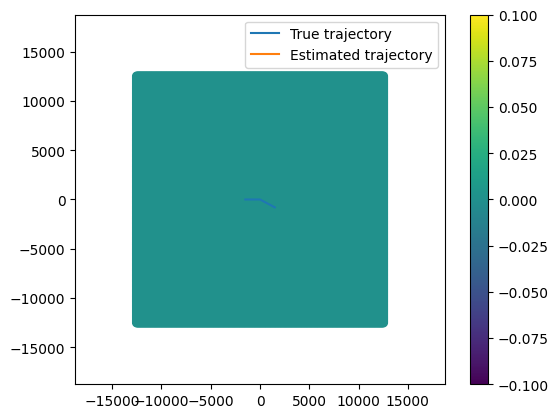

In [23]:
landscape.scatter()
plot_trajectories(ground_truth, label="True trajectory")
plot_trajectories(trace_state[:, :2], label="Estimated trajectory")

# show_n_particles = 10
# plot_trajectories(trace_all_particles[:, :show_n_particles, :2].swapaxes(1, 0), label=None)

scale = 1.5
plt.gca().set_xlim(-width / 2 * scale, width / 2 * scale)
plt.gca().set_ylim(-height / 2 * scale, height / 2 * scale)

plt.colorbar()
plt.legend()
pass

In [24]:
coordinates = trace_all_particles[:, :, :2]

# Shape is (time, particles, state)
coordinates.shape

(53, 50, 2)

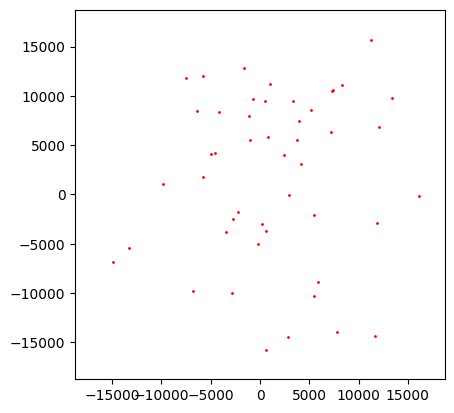

In [25]:
plt.gca().set_aspect("equal")
plt.scatter(*coordinates[40, ...].T, c="r", s=1)
plt.xlim(-width / 2 * scale, width / 2 * scale)
plt.ylim(-height / 2 * scale, height / 2 * scale)

pass

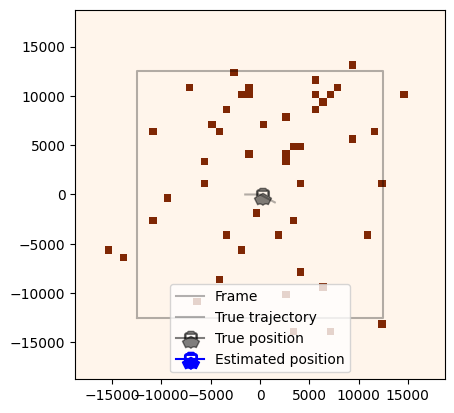

In [26]:
index = 30

plt.gca().set_aspect("equal")

# draw a box around the frame (-1500, -1500) to (1500, 1500)
plt.plot(
    [-width / 2, width / 2, width / 2, -width / 2, -width / 2],
    [-height / 2, -height / 2, height / 2, height / 2, -height / 2],
    "k-",
    alpha=0.3,
    label="Frame",
)

plot_trajectories(ground_truth, label="True trajectory", color="k", alpha=0.3)

plt.hist2d(
    *coordinates[index, ...].T,
    bins=50,
    range=[[-width / 2 * scale, width / 2 * scale], [-height / 2 * scale, height / 2 * scale]],
    cmap="Oranges",
)

ship_marker = parse_path(svg2paths("ship-icon.svg")[1][0]["d"])
ship_marker.vertices -= ship_marker.vertices.mean(axis=0)
ship_marker = ship_marker.transformed(Affine2D().rotate_deg(180)).transformed(
    Affine2D().scale(-1, 1)
)

if index > 0:
    # Plot the ship position and position estimate at that time point
    plt.gca().plot(
        *ground_truth[index - 1],
        marker=ship_marker,
        markersize=14,
        label="True position",
        c="k",
        alpha=0.5,
    )
    plt.gca().plot(
        *trace_state[index - 1, :2],
        marker=ship_marker,
        markersize=14,
        label="Estimated position",
        c="b",
    )


plt.legend()
pass

In [81]:
vessel_types = json.loads((Path("..") / "data" / "vessel_types_simplified.json").read_text())
# vessel_types

In [28]:
def load_ais(
    path: str | Path, bbox: None | tuple[tuple[float, float], tuple[float, float]]
) -> pd.DataFrame:
    # Read the csv into pandas
    df = pd.read_csv(path)

    # Filter by bounding box
    if bbox is not None:
        # This is a overly simplistic bounding box filter that only works on moderate latitudes
        # and far from the dateline
        df = df[
            (df["LAT"] > bbox[0][0])
            & (df["LAT"] < bbox[1][0])
            & (df["LON"] > bbox[0][1])
            & (df["LON"] < bbox[1][1])
        ]

    # Sort by time per ship
    df.sort_values(["MMSI", "BaseDateTime"], inplace=True)

    df.loc[df["VesselType"].isna(), "VesselType"] = 0  # Zero means unknown

    df["VesselType"] = df["VesselType"].astype(int)
    df["VesselTypeName"] = df["VesselType"].astype(str).map(vessel_types)

    return df


setting = "New York Harbor"
bbox = (
    # (lat, lon) lower left
    (40.4, -74.1),
    # (lat, lon) upper right
    (40.7, -73.7),
)

# setting = "Port of Charleston, South Carolina"
# bbox = (
#     # (lat, lon) lower left
#     (32.75, -79.97),
#     # (lat, lon) upper right
#     (32.875, -79.87),
# )

# setting = "Baltimore"
# bbox = (
#     # (lat, lon) lower left
#     (39.174, -76.6304993),
#     # (lat, lon) upper right
#     (39.29, -76.4495423),
# )

# setting = "Port of Virginia (Norfolk)"
# bbox = (
#     # (lat, lon) lower left
#     (36.7711453, -76.4994133),
#     # (lat, lon) upper right
#     (37.3020172, -75.8786833),
# )

df = load_ais(Path("..") / "data" / "ais" / "AIS_2023_08_01.csv", bbox=bbox)
df

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TransceiverClass,VesselTypeName
4127220,99258652,2023-08-01T12:17:26,40.64471,-74.02892,0.2,360.0,511.0,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,A,Not available
6356009,232040168,2023-08-01T18:14:16,40.41563,-74.02070,102.3,71.0,106.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6390267,232040168,2023-08-01T18:22:00,40.41702,-74.01857,5.5,31.8,41.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6391376,232040168,2023-08-01T18:24:03,40.42008,-74.01790,7.9,349.8,2.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
6418027,232040168,2023-08-01T18:27:35,40.42827,-74.01943,9.5,352.2,358.0,DANCING BEAR,IMO0000000,MKTD4,37,NaN,0.0,0.0,NaN,NaN,B,Pleasure craft
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8317539,636093148,2023-08-01T23:45:44,40.67079,-74.07980,0.0,299.0,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous"
8313370,636093148,2023-08-01T23:48:44,40.67079,-74.07980,0.0,299.1,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous"
8354899,636093148,2023-08-01T23:51:44,40.67079,-74.07980,0.0,299.1,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous"
8351117,636093148,2023-08-01T23:54:45,40.67079,-74.07980,0.0,299.2,299.0,TANGIER EXPRESS,IMO9525900,5LDS8,74,5.0,366.0,48.0,11.8,74.0,A,"Cargo, hazardous"


In [29]:
MMSIs = df["MMSI"].value_counts()
relevant_MMSIs = MMSIs[MMSIs > 20].index
df = df[df["MMSI"].isin(relevant_MMSIs)]

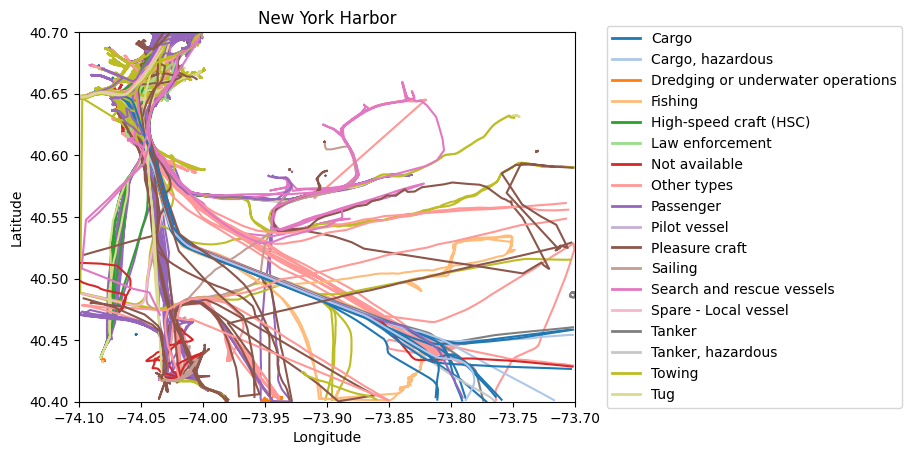

In [30]:
vessel_type_to_index = {
    vessel_type: i for i, vessel_type in enumerate(sorted(df["VesselTypeName"].unique()))
}
palette = sns.color_palette("tab20", len(vessel_type_to_index))

for mmsi in relevant_MMSIs:
    df_ = df[df["MMSI"] == mmsi]
    vessel_type = df_["VesselTypeName"].iloc[0]
    color = palette[vessel_type_to_index[vessel_type]]
    plt.plot(df_["LON"], df_["LAT"], c=color)
    # plt.scatter(df_["LON"], df_["LAT"], c=df_["SOG"], cmap="viridis", s=8)

# plt.colorbar()

plt.xlim(bbox[0][1], bbox[1][1])
plt.xlabel("Longitude")
plt.ylim(bbox[0][0], bbox[1][0])
plt.ylabel("Latitude")

plt.legend(
    [
        plt.Line2D([0], [0], color=palette[i], lw=2, label=vessel_type)
        for i, vessel_type in enumerate(vessel_type_to_index)
    ],
    vessel_type_to_index.keys(),
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
)

plt.title(setting)

plt.savefig(Path(".") / "plots" / f"ais-{setting}.pdf", dpi=300, bbox_inches="tight")

pass